In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 把语音问题转换为图像问题

## 导入库

In [4]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from fastai.vision.all import *
import os

## 使用fastai的中级api, 直接把音频作为数据集, 

In [5]:
path = Path('/kaggle/input/audio-emotions/Emotions')
path.ls()

(#7) [Path('/kaggle/input/audio-emotions/Emotions/Suprised'),Path('/kaggle/input/audio-emotions/Emotions/Fearful'),Path('/kaggle/input/audio-emotions/Emotions/Disgusted'),Path('/kaggle/input/audio-emotions/Emotions/Angry'),Path('/kaggle/input/audio-emotions/Emotions/Neutral'),Path('/kaggle/input/audio-emotions/Emotions/Sad'),Path('/kaggle/input/audio-emotions/Emotions/Happy')]

In [6]:
def audio_to_image(file_path, target_shape=(128, 128)):
    y, sr = librosa.load(file_path, sr=None)
    y_stretched = librosa.effects.time_stretch(y, rate=1)
    mel_spectrogram = librosa.feature.melspectrogram(y=y_stretched, sr=sr)
    mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)
    
    fig, ax = plt.subplots(figsize=(target_shape[0] / 100, target_shape[1] / 100), dpi=100)
    ax.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    img = img.resize(target_shape)
    buf.close()
    plt.close(fig)
    
    return img

In [ ]:

def get_audio_files(path):
    audio_files = []
    for emotion_dir in os.listdir(path):
        emotion_path = path / emotion_dir
        if os.path.isdir(emotion_path):
            for file in os.listdir(emotion_path):
                if file.endswith(".wav"):
                    audio_files.append(emotion_path / file)
    return audio_files

def audio_to_image_fn(file_path):
    return PILImage.create(np.array(audio_to_image(file_path)))

# 获取所有音频文件
audio_files = get_audio_files(path)

# 创建标签
labels = [parent_label(f) for f in audio_files]

# 创建DataLoaders
def get_x(file_path):
    return audio_to_image_fn(file_path)

def get_y(file_path):
    return parent_label(file_path)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_audio_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_y,
    get_x=get_x,
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(size=224) # resnet18的shape
)

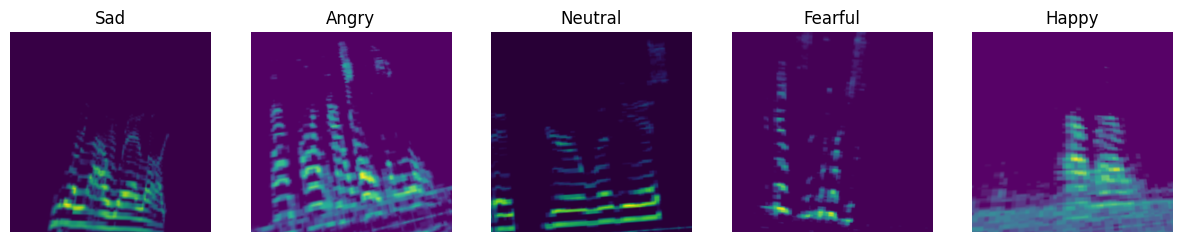

In [ ]:
dls = dblock.dataloaders(path)
dls.show_batch(nrows=1, ncols=5)

In [11]:
learn = vision_learner(dls, resnet18, metrics=accuracy).to_fp16()

## 数据预处理
我们发现调用librosa把音频转换梅尔频谱图需要大量时间(一轮20分钟左右, 而实际使用GPU训练时间在30s左右), 对此我们决定先把音频转换成图片存储, 直接使用图片训练

In [17]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from fastai.vision.all import *
import os

input_path = Path('/kaggle/input/audio-emotions/Emotions')
output_path = Path('/kaggle/working/emotions_images')
output_path.mkdir(parents=True, exist_ok=True)

def audio_to_image(file_path, target_shape=(128, 128)):
    y, sr = librosa.load(file_path, sr=None)
    y_stretched = librosa.effects.time_stretch(y, rate=1)
    mel_spectrogram = librosa.feature.melspectrogram(y=y_stretched, sr=sr)
    mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)
    
    fig, ax = plt.subplots(figsize=(target_shape[0] / 100, target_shape[1] / 100), dpi=100)
    ax.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    img = img.resize(target_shape)
    buf.close()
    plt.close(fig)
    
    return img

def save_audio_as_image(input_path, output_path, target_shape=(128, 128)):
    for emotion_dir in os.listdir(input_path):
        emotion_path = input_path / emotion_dir
        if os.path.isdir(emotion_path):
            save_path = output_path / emotion_dir
            save_path.mkdir(parents=True, exist_ok=True)
            for file in os.listdir(emotion_path):
                if file.endswith(".wav"):
                    img = audio_to_image(emotion_path / file, target_shape=target_shape)
                    img.save(save_path / (file.replace('.wav', '.png')))

save_audio_as_image(input_path, output_path)

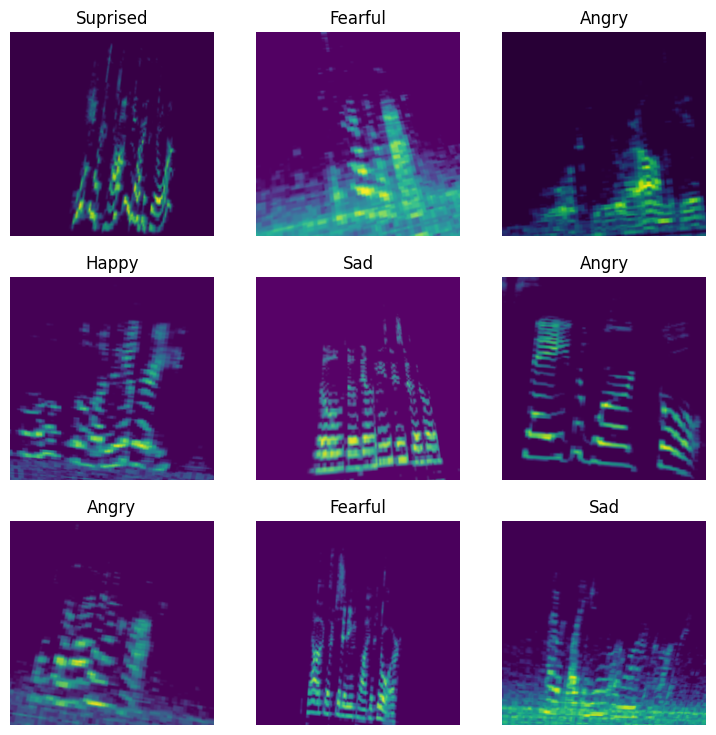

In [28]:
from fastai.vision.all import *

# 加载图像文件
def get_image_files(path):
    return [item for sublist in [list((path/f).rglob('*.png')) for f in os.listdir(path)] for item in sublist]

# 创建DataBlock
image_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(size=224) # resnet18需要
)

# 生成数据加载器
input_path = Path('/kaggle/input/emotions-images')
dls = image_block.dataloaders(input_path, bs=64)
dls.show_batch(nrows=3, ncols=3)

In [29]:
image_block.summary(input_path)

Setting-up type transforms pipelines
Found 12798 items
2 datasets of sizes 10239,2559
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /kaggle/input/emotions-images/Sad/1002_MTI_SAD_XX.png
    applying PILBase.create gives
      PILImage mode=RGB size=128x128
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /kaggle/input/emotions-images/Sad/1002_MTI_SAD_XX.png
    applying parent_label gives
      Sad
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(5)

Final sample: (PILImage mode=RGB size=128x128, TensorCategory(5))


Found 12798 items
2 datasets of sizes 10239,2559
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_i

## 微调

In [31]:
# 创建CNN模型
learn = vision_learner(dls, resnet18, metrics=accuracy)

# 训练模型
learn.fine_tune(20)

epoch,train_loss,valid_loss,accuracy,time
0,2.133460,1.406995,0.463462,00:30


epoch,train_loss,valid_loss,accuracy,time
0,1.542867,1.191634,0.532239,00:39
1,1.318024,1.100148,0.565064,00:38
2,1.204840,1.039748,0.587730,00:38
3,1.088977,0.999546,0.610785,00:38
4,1.021258,0.955756,0.641266,00:38
5,0.960408,0.943932,0.634623,00:38
6,0.916556,0.892764,0.666276,00:38
7,0.857984,0.901288,0.650254,00:38
8,0.796738,0.862559,0.672138,00:38
9,0.755864,0.840971,0.681907,00:38


In [32]:
# 评估模型
learn.validate()

(#2) [0.8386041522026062,0.7186400890350342]

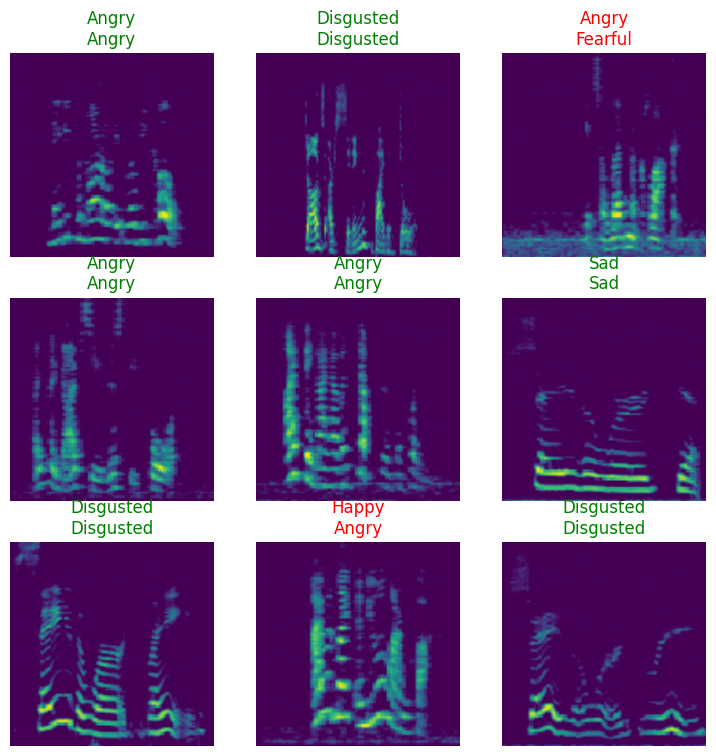

In [34]:
# 显示一些预测
learn.show_results()

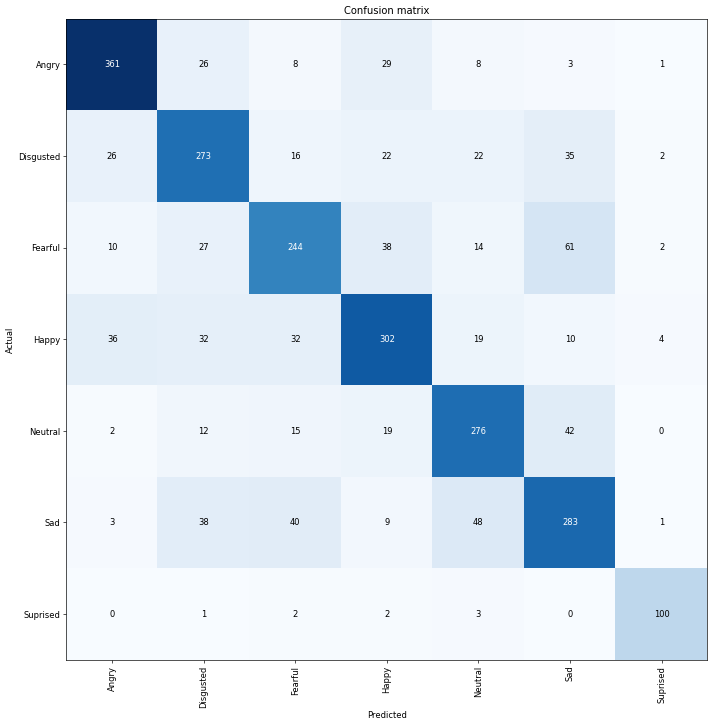

In [35]:
# # 混淆矩阵
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [38]:
interp.most_confused(min_val=20)

[('Fearful', 'Sad', 61),
 ('Sad', 'Neutral', 48),
 ('Neutral', 'Sad', 42),
 ('Sad', 'Fearful', 40),
 ('Fearful', 'Happy', 38),
 ('Sad', 'Disgusted', 38),
 ('Happy', 'Angry', 36),
 ('Disgusted', 'Sad', 35),
 ('Happy', 'Disgusted', 32),
 ('Happy', 'Fearful', 32),
 ('Angry', 'Happy', 29),
 ('Fearful', 'Disgusted', 27),
 ('Angry', 'Disgusted', 26),
 ('Disgusted', 'Angry', 26),
 ('Disgusted', 'Happy', 22),
 ('Disgusted', 'Neutral', 22)]

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 150MB/s] 


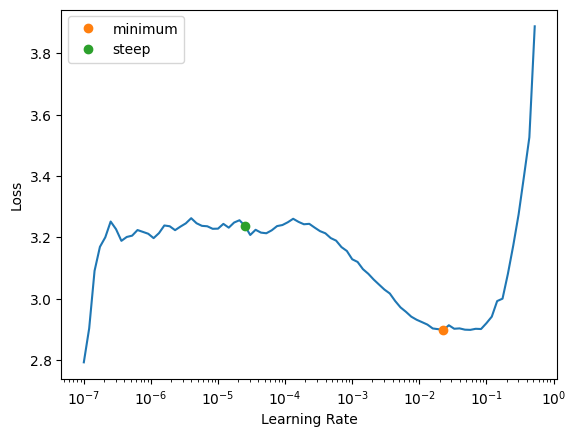

In [39]:
# 学习率查找
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

 ## 解冻和迁移学习

In [42]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(2, 2e-5)

epoch,train_loss,valid_loss,error_rate,time
0,2.834345,1.927260,0.712778,00:45
1,2.503109,1.805385,0.672919,00:44


In [43]:
learn.unfreeze()

SuggestedLRs(valley=0.0002754228771664202)

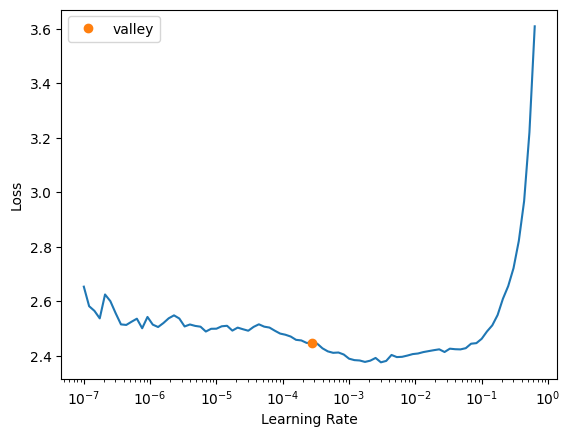

In [44]:
learn.lr_find()

In [45]:
learn.fit_one_cycle(6, lr_max=2e-4)

epoch,train_loss,valid_loss,error_rate,time
0,1.932139,1.335929,0.510746,00:58
1,1.430479,1.114295,0.424775,00:58
2,1.153674,1.028598,0.392732,00:58
3,1.047337,0.953575,0.362251,00:58
4,0.948662,0.826928,0.316921,00:58
5,0.848119,0.805064,0.311059,00:58


## 使用一些归一化技巧

In [46]:
# 应用 Mixup
mixup = MixUp()

# 将 Mixup 作为回调传递给 Learner
learn = vision_learner(dls, resnet18, metrics=accuracy, cbs=mixup)

# 训练模型
learn.fine_tune(20)

epoch,train_loss,valid_loss,accuracy,time
0,2.288502,1.503929,0.428292,00:31


epoch,train_loss,valid_loss,accuracy,time
0,1.802559,1.252429,0.511528,00:39
1,1.646087,1.176824,0.541227,00:38
2,1.510474,1.101915,0.574052,00:38
3,1.411394,1.070936,0.589683,00:38
4,1.345553,0.999544,0.600625,00:38
5,1.286925,0.981708,0.610785,00:39
6,1.254961,0.945025,0.635795,00:38
7,1.223773,0.921788,0.638531,00:38
8,1.184628,0.886826,0.655725,00:38
9,1.157057,0.895598,0.661587,00:39


In [49]:
learn.validate()

(#2) [0.7701223492622375,0.7209847569465637]

In [48]:
# 使用测试时间增强进行预测
tta_preds, tta_targets = learn.tta(dl=dls.valid)

# 计算TTA后的准确率
accuracy_tta = accuracy(tta_preds, tta_targets)
print(f'TTA Accuracy: {accuracy_tta.item():.4f}')

TTA Accuracy: 0.7225


In [50]:
# 应用 Mixup
mixup = MixUp()

# 将 Mixup 作为回调传递给 Learner
learn = vision_learner(dls, resnet34, metrics=accuracy, cbs=mixup)

# 训练模型
learn.fine_tune(20)

epoch,train_loss,valid_loss,accuracy,time
0,2.331951,1.524372,0.429465,00:45


epoch,train_loss,valid_loss,accuracy,time
0,1.814651,1.252399,0.511528,00:58
1,1.601011,1.118942,0.554904,00:58
2,1.470199,1.050877,0.593982,00:58
3,1.378627,1.007330,0.602970,00:58
4,1.322996,1.029768,0.608050,00:58
5,1.275262,0.965522,0.634232,00:58
6,1.239087,0.888525,0.667839,00:58
7,1.187457,0.877343,0.665885,00:58
8,1.149754,0.890628,0.656897,00:58
9,1.123796,0.890422,0.668621,00:58


In [51]:
learn.validate()

(#2) [0.7577505707740784,0.7303634285926819]

## 使用迁移学习的效果也就那样

In [3]:
# 首先我感觉梅尔频谱图有点问题, 让我们重新创建
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path
import io
from fastai.vision.all import *

# 定义路径
path = Path('/kaggle/input/audio-emotions/Emotions')
dest = Path('/kaggle/working/emotions-images_new')

# 创建目标文件夹
dest.mkdir(parents=True, exist_ok=True)

# 将音频文件转换为Mel频谱图并保存
def audio_to_image(file_path, save_path, target_shape=(200, 80)):
    y, sr = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)
    
    # Plot the Mel spectrogram using matplotlib
    fig, ax = plt.subplots(figsize=(target_shape[0] / 100, target_shape[1] / 100), dpi=100)
    ax.axis('off')  # No axes for the image
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    
    # Save plot to image file
    plt.savefig(save_path, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)

# 获取所有音频文件并转换为图像
def process_audio_files_to_images(path, dest):
    audio_files = get_audio_files(path)
    for audio_file in audio_files:
        emotion = parent_label(audio_file)
        save_dir = dest / emotion
        save_dir.mkdir(parents=True, exist_ok=True)
        save_path = save_dir / (audio_file.stem + '.png')
        audio_to_image(audio_file, save_path)

# 获取所有音频文件
def get_audio_files(path):
    audio_files = []
    for emotion_dir in os.listdir(path):
        emotion_path = path / emotion_dir
        if os.path.isdir(emotion_path):
            for file in os.listdir(emotion_path):
                if file.endswith(".wav"):
                    audio_files.append(emotion_path / file)
    return audio_files

# 处理并保存音频文件为图像
process_audio_files_to_images(path, dest)

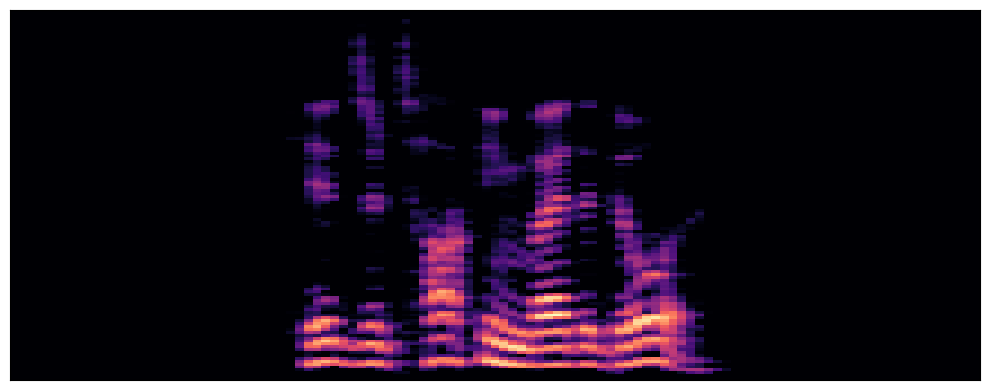

In [65]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 加载音频文件
file_path = '/kaggle/input/audio-emotions/Emotions/Happy/03-01-03-01-01-01-01.wav'  # 替换为你的音频文件路径
y, sr = librosa.load(file_path, sr=44100)

# 计算Mel频谱图
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)

# 绘制Mel频谱图
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sr)
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [5]:
# 将图像打包成ZIP文件
def create_zip_from_directory(directory, zip_filename):
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(directory):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, directory)
                zipf.write(file_path, arcname)

# 定义ZIP文件路径
zip_filename = '/kaggle/working/emotions-images_new1.zip'

# 创建ZIP文件
create_zip_from_directory(dest, zip_filename)

print(f"ZIP file created: {zip_filename}")

ZIP file created: /kaggle/working/emotions-images_new1.zip


# 从语音中提取特征
我们参考了最近几年语音分类的项目, 效果比较好的都是选择从语音中提取特征, 可能语音问题就不适合用图像去解决!!!</br>
因此我不得不重新思考这个问题...

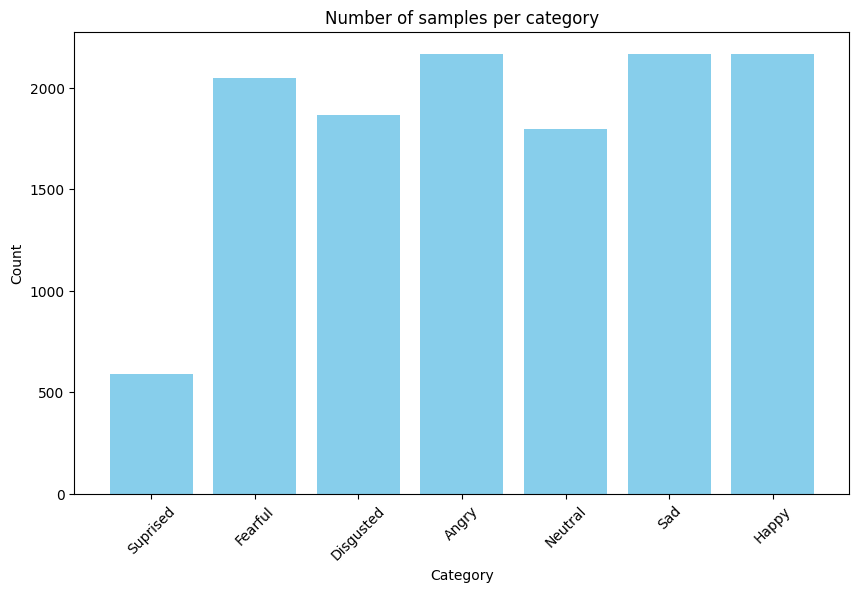

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 定义数据集路径
data_path = "/kaggle/input/audio-emotions/Emotions"

# 获取所有类别的目录名称
categories = os.listdir(data_path)

# 初始化一个字典来存储每个类别的样本数量
category_counts = {category: 0 for category in categories}

# 遍历每个类别目录，统计每个类别的样本数量
for category in categories:
    category_dir = os.path.join(data_path, category)
    category_counts[category] = len([f for f in os.listdir(category_dir) if f.endswith('.wav')])

# 将结果转换为DataFrame以便绘图
df_counts = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(df_counts['Category'], df_counts['Count'], color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Number of samples per category')
plt.xticks(rotation=45)
plt.show()

## 选择一个样本, 尝试提取特征

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

# 读取音频文件
sample_path = "/kaggle/input/audio-emotions/Emotions/Angry/03-01-05-01-01-01-01.wav"
data, sr = librosa.load(sample_path)

In [19]:
ipd.Audio(data,rate=sr)

### mel频谱图

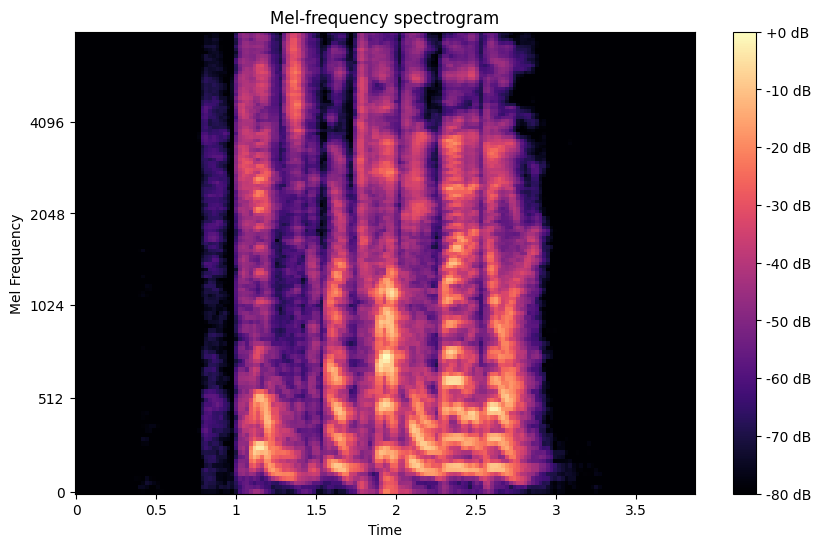

In [20]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# 计算mel频谱图
n_mels = 128
fmax = 8000
S = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax)

# 转换为dB
S_dB = librosa.power_to_db(S, ref=np.max)

# 绘制mel频谱图
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=fmax)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.show()

### MFCC

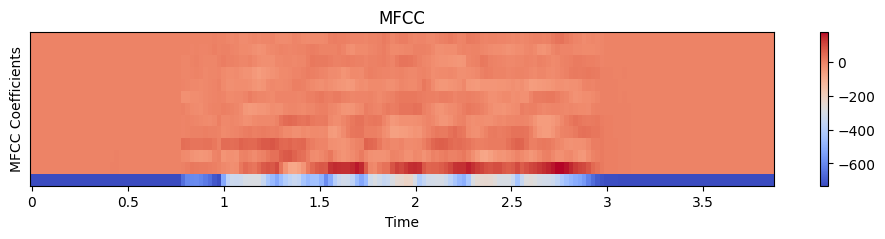

In [21]:
mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)

# 绘制MFCC
plt.figure(figsize=(12, 2))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

### 尝试一些数据增强方法

### 添加噪声

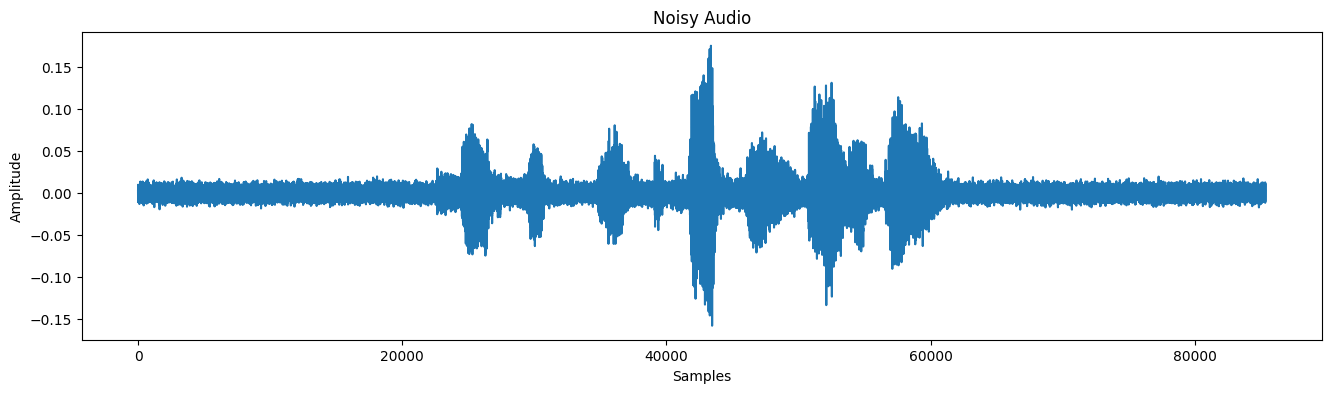

In [22]:
def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    return augmented_data

noisy_data = add_noise(data)

# 播放添加噪声后的音频
ipd.display(ipd.Audio(noisy_data, rate=sr))

# 绘制波形图
plt.figure(figsize=(16, 4))
plt.plot(noisy_data)
plt.title('Noisy Audio')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

### 时间偏移

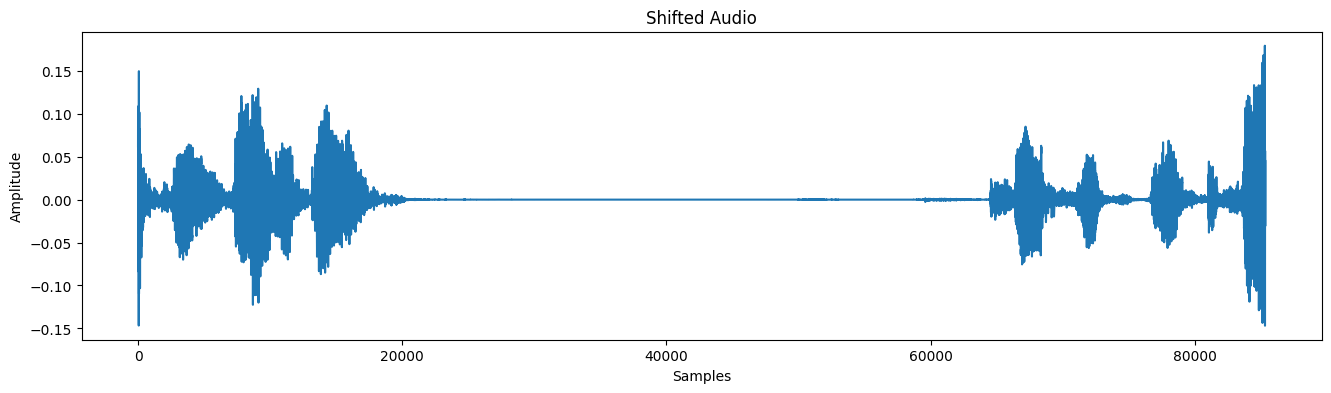

In [23]:
def shift(data, shift_max, shift_direction='both'):
    shift = np.random.randint(sr * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.choice(['left', 'right'])
        if direction == 'right':
            shift = -shift
    augmented_data = np.roll(data, shift)
    return augmented_data

shifted_data = shift(data, shift_max=2)

# 播放时间偏移后的音频
ipd.display(ipd.Audio(shifted_data, rate=sr))

# 绘制波形图
plt.figure(figsize=(16, 4))
plt.plot(shifted_data)
plt.title('Shifted Audio')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

### 音高变化

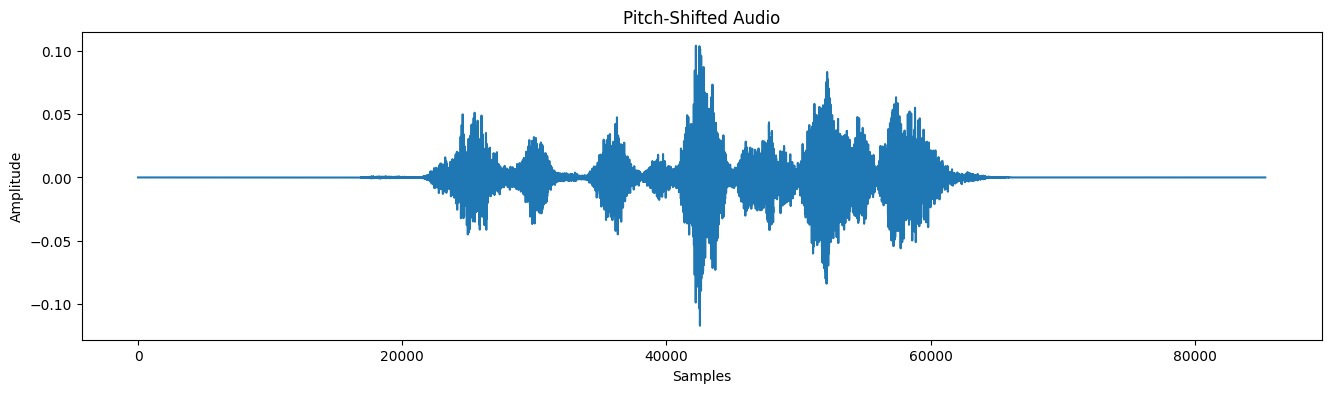

In [24]:
def pitch_shift(data, sr, n_steps):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

pitched_data = pitch_shift(data, sr, n_steps=2)

# 播放音高变化后的音频
ipd.display(ipd.Audio(pitched_data, rate=sr))

# 绘制波形图
plt.figure(figsize=(16, 4))
plt.plot(pitched_data)
plt.title('Pitch-Shifted Audio')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

## 特征提取函数

In [25]:
import numpy as np
import pandas as pd
import librosa

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    # 提取零交叉率（ZCR）特征
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    zcr = np.squeeze(zcr)

    # 提取均方根能量（RMSE）特征
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    rmse = np.squeeze(rmse)

    # 提取增强的 MFCC 特征
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    mfcc = np.ravel(mfcc.T)
    
#     print(len(zcr), len(rmse), len(mfcc))
    
    features = np.hstack([zcr, rmse, mfcc])
    
    return features

In [26]:
# 测试提取特征函数
sample_path = "/kaggle/input/audio-emotions/Emotions/Angry/03-01-05-01-01-01-01.wav"
data, sr = librosa.load(sample_path, duration=2.0, offset=0.3)
features = extract_features(data, sr)

# 显示提取的特征
print("Extracted Features Shape:", features.shape)
print("Extracted Features:", features)


Extracted Features Shape: (1914,)
Extracted Features: [ 0.36376953  0.54052734  0.67285156 ... -7.24713421  8.36530399
  3.89563942]


In [27]:
# 选取另一个样本是为了保证选取的特征数量一致

# 测试提取特征函数
sample_path = "/kaggle/input/audio-emotions/Emotions/Disgusted/1002_IEO_DIS_MD.wav"
data, sr = librosa.load(sample_path, duration=2.0, offset=0.3)
features = extract_features(data, sr)

# 显示提取的特征
print("Extracted Features Shape:", features.shape)
print("Extracted Features:", features)

Extracted Features Shape: (1914,)
Extracted Features: [ 0.02246094  0.03125     0.04345703 ... -8.11434269 -2.391855
 -1.42758703]


## 数据增强

In [28]:
import numpy as np
import pandas as pd
import librosa

def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    return augmented_data

def shift(data, sr, shift_max, shift_direction='both'):
    shift = np.random.randint(sr * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.choice(['left', 'right'])
        if direction == 'right':
            shift = -shift
    augmented_data = np.roll(data, shift)
    return augmented_data

def pitch_shift(data, sr, n_steps):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

# 处理单个文件
def process_file(file_path, target_duration=2.0, target_sr=22050, offset=0.3):
    data, sr = librosa.load(file_path, sr=target_sr, offset=offset)
    
    # 如果音频长度不足 target_duration 秒，则进行填充
    if len(data) < target_duration * sr:
        padding = target_duration * sr - len(data)
        data = np.pad(data, (0, int(padding)), 'constant')
    else:
        data = data[:int(target_duration * sr)]
    
    # 原始特征
    features = extract_features(data, sr)
    
    # 数据增强和特征提取
    augmented_features = []
    augmented_features.append(features)
    
    # 添加噪声
    noisy_data = add_noise(data)
    noisy_features = extract_features(noisy_data, sr)
    augmented_features.append(noisy_features)
    
    # 时间偏移
    shifted_data = shift(data, sr, shift_max=2)
    shifted_features = extract_features(shifted_data, sr)
    augmented_features.append(shifted_features)
    
    # 音高变化
    pitched_data = pitch_shift(data, sr, n_steps=2)
    pitched_features = extract_features(pitched_data, sr)
    augmented_features.append(pitched_features)
    
    return augmented_features

# 测试处理单个文件
sample_path = "/kaggle/input/audio-emotions/Emotions/Angry/03-01-05-01-01-01-01.wav"
augmented_features = process_file(sample_path)
# 显示提取的特征
print("Augmented Features Shape:", [f.shape for f in augmented_features])
print("Augmented Features:", augmented_features)

Augmented Features Shape: [(1914,), (1914,), (1914,), (1914,)]
Augmented Features: [array([ 0.36376953,  0.54052734,  0.67285156, ..., -7.22594833,
        8.36521149,  4.02894592]), array([  0.25      ,   0.3828125 ,   0.49951172, ..., -10.07031189,
         0.95282672,   4.74834905]), array([  0.02636719,   0.1171875 ,   0.18212891, ...,  -6.26894379,
       -12.22416973,  -1.83925366]), array([ 0.24121094,  0.34472656,  0.45849609, ...,  5.65659857,
       -1.96814322, -2.08656478])]


In [29]:
# 测试处理单个文件
sample_path = "/kaggle/input/audio-emotions/Emotions/Disgusted/1002_IEO_DIS_MD.wav"
augmented_features = process_file(sample_path)
# 显示提取的特征
print("Augmented Features Shape:", [f.shape for f in augmented_features])
print("Augmented Features:", augmented_features)

Augmented Features Shape: [(1914,), (1914,), (1914,), (1914,)]
Augmented Features: [array([ 0.02246094,  0.03125   ,  0.04345703, ..., -8.05968857,
       -2.36656475, -1.42319429]), array([ 0.19970703,  0.2890625 ,  0.38427734, ..., -1.79239534,
       -3.4965272 , -4.48866558]), array([ 0.02197266,  0.03173828,  0.04248047, ..., -0.60158575,
       -3.03523874, -3.44099832]), array([ 0.02099609,  0.03271484,  0.04003906, ...,  2.31648922,
       -0.9786694 , -6.86550617])]


## 数据预处理
读取特征, 保存特征

In [30]:
import os
import time
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm

# 批量处理所有音频文件
def process_all_files(data_path):
    # 获取所有类别的目录名称
    categories = os.listdir(data_path)
    
    all_features = []
    all_labels = []

    start_time = time.time()
    
    # 遍历每个类别目录，提取每个音频文件的特征
    for category in categories:
        category_dir = os.path.join(data_path, category)
        for file_name in tqdm(os.listdir(category_dir), desc=f'Processing {category}'):
            if file_name.endswith('.wav'):
                file_path = os.path.join(category_dir, file_name)
                augmented_features = process_file(file_path)
                for features in augmented_features:
                    all_features.append(features)
                    all_labels.append(category)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Processing time: {elapsed_time:.2f} seconds")
    
    return np.array(all_features), np.array(all_labels)

# 定义数据集路径
data_path = "/kaggle/input/audio-emotions/Emotions"

# 处理所有文件并获取特征和标签
all_features, all_labels = process_all_files(data_path)

# 将特征和标签转换为 DataFrame
df_features = pd.DataFrame(all_features)
df_features['label'] = all_labels

Processing Happy: 100%|██████████| 2167/2167 [05:12<00:00,  6.94it/s]


Processing time: 1815.73 seconds


In [31]:
# import ace_tools as tools; tools.display_dataframe_to_user(name="Extracted Features", dataframe=df_features)
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,1905,1906,1907,1908,1909,1910,1911,1912,1913,label
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.159821,-13.579152,-14.357656,-6.026750,-7.200257,-10.158033,-9.531046,-8.818936,-4.641337,Suprised
1,0.251465,0.384277,0.503418,0.506836,0.512695,0.507324,0.507812,0.503906,0.494629,0.491699,...,6.583082,-8.579205,-15.144431,-8.335957,-7.936537,-5.422759,-12.162390,-6.042157,-2.369513,Suprised
2,0.053711,0.083008,0.109375,0.112305,0.149414,0.213379,0.206055,0.205078,0.148926,0.063965,...,4.956180,5.058086,4.853603,-14.776800,-2.144962,1.641350,-1.453103,-6.399162,-9.667449,Suprised
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002441,0.142578,0.264160,...,0.245735,-10.770325,3.085566,-7.844700,-15.909744,-16.324821,-5.055079,-7.516734,11.870403,Suprised
4,0.050781,0.082520,0.094727,0.090332,0.075195,0.093262,0.145508,0.204590,0.250977,0.241211,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Suprised


In [32]:
import pandas as pd
# 保存特征和标签到CSV文件
df_features.to_csv('/kaggle/working/audio_emotions_features.csv', index=False)

# 保存点

In [6]:
import pandas as pd
# 加载保存的CSV文件
df_loaded_features = pd.read_csv('/kaggle/input/audio-emotions-features/audio_emotions_features.csv')

# 检查加载的数据
print(df_loaded_features.head())
print("Loaded Features Shape:", df_loaded_features.shape)

          0         1         2         3         4         5         6  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.251465  0.384277  0.503418  0.506836  0.512695  0.507324  0.507812   
2  0.053711  0.083008  0.109375  0.112305  0.149414  0.213379  0.206055   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.050781  0.082520  0.094727  0.090332  0.075195  0.093262  0.145508   

          7         8         9  ...       1905       1906       1907  \
0  0.000000  0.000000  0.000000  ...  10.159821 -13.579152 -14.357656   
1  0.503906  0.494629  0.491699  ...   6.583082  -8.579205 -15.144431   
2  0.205078  0.148926  0.063965  ...   4.956180   5.058086   4.853603   
3  0.002441  0.142578  0.264160  ...   0.245735 -10.770325   3.085566   
4  0.204590  0.250977  0.241211  ...   0.000000   0.000000   0.000000   

        1908       1909       1910       1911      1912       1913     label  
0  -6.026750  -7.200257 -10.158

## 加载数据

In [7]:
# 将 'label' 列转换为分类数据类型
df_loaded_features['label'] = df_loaded_features['label'].astype('category')

label_categories = df_loaded_features['label'].cat.categories
print(label_categories)

y = df_loaded_features['label'].cat.codes

Index(['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Suprised'], dtype='object')


In [8]:
y_cat = [label_categories[y[i]] for i in range(len(y))]
y_cat[-10:]

['Happy',
 'Happy',
 'Happy',
 'Happy',
 'Happy',
 'Happy',
 'Happy',
 'Happy',
 'Happy',
 'Happy']

In [9]:
len(y_cat)

51192

In [10]:
import numpy as np
# 划分特征和标签
X = df_loaded_features.drop(columns=['label'])
y = df_loaded_features['label']

# 增加一个维度
X = X.values.reshape(-1, 1, 1914).astype(np.float32)

X.shape

(51192, 1, 1914)

In [11]:
X[1].shape

(1, 1914)

In [12]:
from fastai.vision.all import *
import numpy as np

def get_x(r): return X[r]
def get_y(r): return y_cat[r]

# DataBlock
dblock = DataBlock(blocks=(TransformBlock, CategoryBlock),
                   getters=[get_x, get_y],
                   splitter=RandomSplitter(valid_pct=0.2, seed=42))  # 20%的数据用作验证集

dls = dblock.dataloaders(np.arange(len(X)), bs=512)

In [13]:
x_train, y_train = dls.train.one_batch()
x_train.shape

torch.Size([512, 1, 1914])

## CNN

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(FastaiCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 512, kernel_size=5, stride=1, padding='same')
        self.bn1 = nn.BatchNorm1d(512)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        
        self.conv2 = nn.Conv1d(512, 512, kernel_size=5, stride=1, padding='same')
        self.bn2 = nn.BatchNorm1d(512)
        self.pool2 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.dropout2 = nn.Dropout(0.2)
        
        self.conv3 = nn.Conv1d(512, 256, kernel_size=5, stride=1, padding='same')
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        
        self.conv4 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding='same')
        self.bn4 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.dropout4 = nn.Dropout(0.2)
        
        self.conv5 = nn.Conv1d(256, 128, kernel_size=3, stride=1, padding='same')
        self.bn5 = nn.BatchNorm1d(128)
        self.pool5 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.dropout5 = nn.Dropout(0.2)
        
#         self.fc1 = nn.Linear(128 * 30, 512)
        self.fc1 = nn.Linear(128 * 60, 512)
        self.bn6 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, len(label_categories))
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)
        x = self.dropout5(x)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.fc2(x)
        
        return x

# 创建CNN模型
model = CNN()

In [11]:
# 定义learner
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time
0,1.403458,1.857442,0.313147,01:04


epoch,train_loss,valid_loss,accuracy,time
0,1.112651,1.174992,0.534382,01:04
1,1.023010,1.112129,0.560363,01:04
2,0.958158,1.039608,0.591326,01:04
3,0.893652,0.970540,0.625610,01:04
4,0.851192,1.242606,0.521782,01:04
5,0.806337,1.288658,0.513968,01:04
6,0.761624,0.992395,0.612815,01:04
7,0.713109,0.891653,0.654132,01:04
8,0.674088,0.856789,0.679527,01:04
9,0.624246,0.804578,0.698672,01:04


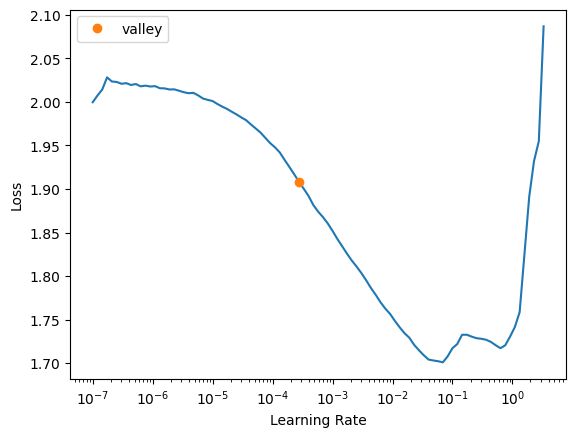

In [12]:
# 查找适合的学习率
learn.lr_find()

# 训练模型
learn.fine_tune(50)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [14]:
# 保存模型
learn.save('audio_emotion_recognition_model')

Path('models/audio_emotion_recognition_model.pth')

## 重构CNN

In [19]:
from fastai.vision.all import *

def conv_block_1d(ni, nf, kernel_size=(5, 5), padding=2, dropout=0.2):
    return nn.Sequential(
        nn.Conv1d(ni, nf, kernel_size=kernel_size[0], stride=1, padding='same'),
        nn.BatchNorm1d(nf),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=kernel_size[1], stride=2, padding=padding),
        nn.Dropout(dropout)
    )

def get_model():
    return nn.Sequential(
        conv_block_1d(1, 512),
        conv_block_1d(512, 512),
        conv_block_1d(512, 256),
        conv_block_1d(256, 256, kernel_size=(3, 5)),
        conv_block_1d(256, 128, kernel_size=(3,3), padding=1),
        nn.AdaptiveAvgPool1d(1),
        Flatten(),
        nn.Linear(128, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, len(label_categories))
    )

def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()

model = get_model()
learn = get_learner(model)

In [ ]:
# 查找适合的学习率
learn.lr_find()

# 训练模型
learn.fit_one_cycle(50)

## 改进CNN
把conv1d作为stem, 主体部分是一个残差网络, 类似resnet18

In [24]:
def _resnet_stem(*sizes):
    return [
        nn.Conv1d(sizes[i], sizes[i+1], kernel_size=3, stride = 2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool1d(kernel_size=3, stride=2, padding=1)]


def _conv_block(ni, nf, stride):
    return nn.Sequential(
        nn.Conv1d(ni, nf, kernel_size=3, stride=stride, padding=1),
        nn.BatchNorm1d(nf),
        nn.ReLU(),
        nn.Conv1d(nf, nf, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(nf)
    )


class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni, nf, stride)
        # 如果输入和输出通道数不同或应用了stride
        if ni != nf or stride != 1:
            self.idconv = nn.Sequential(
                nn.Conv1d(ni, nf, kernel_size=1, stride=stride),
                nn.BatchNorm1d(nf)
            )
        else:
            self.idconv = nn.Identity()

    def forward(self, x):
        identity = self.idconv(x)
        out = self.convs(x)
        return F.relu(out + identity)



class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(1,16, 32, 32, 64) # 我不希望一次增加太多参数, 原:1-->512
#         stem = _resnet_stem(1, 32, 64, 64, 128, 256)
        self.block_szs = [64, 64, 128, 256, 512]
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool1d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))
    
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])

In [25]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()

model = ResNet(dls.c, [2,2,2,2])
learn = get_learner(model)

epoch,train_loss,valid_loss,accuracy,time
0,1.952583,1.809086,0.289314,00:25


epoch,train_loss,valid_loss,accuracy,time
0,1.786141,1.779834,0.299961,00:25
1,1.764526,1.757045,0.303380,00:25
2,1.744747,1.735319,0.313049,00:25
3,1.722035,1.714128,0.317640,00:25
4,1.700550,1.693473,0.323208,00:25
5,1.681218,1.673953,0.334440,00:25
6,1.657982,1.654674,0.334440,00:26
7,1.641775,1.636500,0.344501,00:25
8,1.624725,1.618802,0.353585,00:26
9,1.605394,1.601448,0.360617,00:25


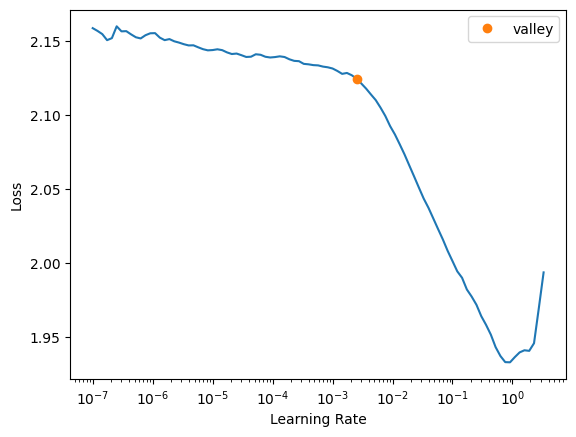

In [36]:
# 查找适合的学习率
# learn.lr_find()

# 训练模型
learn.fine_tune(50)

In [37]:
learn.fine_tune(50)

epoch,train_loss,valid_loss,accuracy,time
0,1.300292,1.311980,0.505567,00:25


epoch,train_loss,valid_loss,accuracy,time
0,1.290248,1.306919,0.509084,00:25
1,1.290503,1.304884,0.510940,00:25
2,1.285167,1.302986,0.510940,00:26
3,1.283227,1.300905,0.511526,00:25
4,1.281269,1.297553,0.513186,00:25
5,1.277512,1.294157,0.513088,00:26
6,1.274483,1.289711,0.514651,00:25
7,1.270210,1.286636,0.518363,00:25
8,1.267639,1.281150,0.523051,00:26
9,1.264503,1.276391,0.526177,00:25


In [38]:
learn.fine_tune(100)

epoch,train_loss,valid_loss,accuracy,time
0,1.129239,1.161486,0.563391,00:25


epoch,train_loss,valid_loss,accuracy,time
0,1.123713,1.149061,0.570033,00:26
1,1.117734,1.147783,0.570815,00:25
2,1.118887,1.148446,0.570619,00:25
3,1.116942,1.146212,0.570717,00:25
4,1.118014,1.145867,0.571108,00:25
5,1.116770,1.145424,0.571205,00:25
6,1.117041,1.144453,0.570424,00:25
7,1.112071,1.143197,0.573061,00:25
8,1.114253,1.142845,0.571987,00:26
9,1.111877,1.141213,0.572084,00:25


真是一点都没有过拟合啊😦, 应该是陷入局部最优了, 尝试调整学习策略

我忘记了微调用于迁移学习,,,,

SuggestedLRs(valley=0.00019054606673307717)

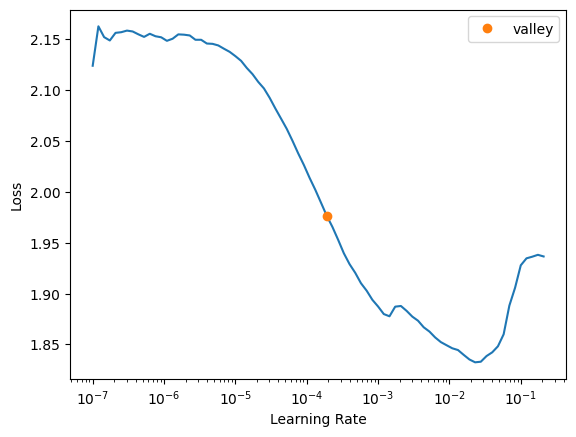

In [28]:
learn.lr_find()

one_cycle会尝试动态学习率, 离开局部最优
![1](https://minio-file.rica.nezuko.me/img/2024/05/15/66446b50881be.png)

In [29]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.440145,1.654659,0.394608,00:26
1,1.211359,2.462880,0.319496,00:25
2,1.066573,1.360952,0.478707,00:26
3,0.953196,1.071550,0.609982,00:25
4,0.860966,1.245069,0.559289,00:25
5,0.760989,0.878530,0.654815,00:26
6,0.652742,0.790750,0.700137,00:26
7,0.523110,0.699030,0.735788,00:25
8,0.380918,0.624295,0.767923,00:26
9,0.295275,0.604670,0.777984,00:25


已经过拟合了, 再训练下去没有意义(现在回过头来看效果还不错, 看应该继续练下去的)

## 早停, 权重衰减

In [26]:
def _resnet_stem(*sizes):
    return [
        nn.Conv1d(sizes[i], sizes[i+1], kernel_size=3, stride = 2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool1d(kernel_size=3, stride=2, padding=1)]


def _conv_block(ni, nf, stride):
    return nn.Sequential(
        nn.Conv1d(ni, nf, kernel_size=3, stride=stride, padding=1),
        nn.BatchNorm1d(nf),
        nn.ReLU(),
        nn.Conv1d(nf, nf, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(nf)
    )


class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni, nf, stride)
        # 如果输入和输出通道数不同或应用了stride
        if ni != nf or stride != 1:
            self.idconv = nn.Sequential(
                nn.Conv1d(ni, nf, kernel_size=1, stride=stride),
                nn.BatchNorm1d(nf)
            )
        else:
            self.idconv = nn.Identity()

    def forward(self, x):
        identity = self.idconv(x)
        out = self.convs(x)
        return F.relu(out + identity)


class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(1,512, 256, 128, 64)
        self.block_szs = [64, 64, 128, 256, 512]
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool1d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))
    
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])

SuggestedLRs(valley=0.00013182566908653826)

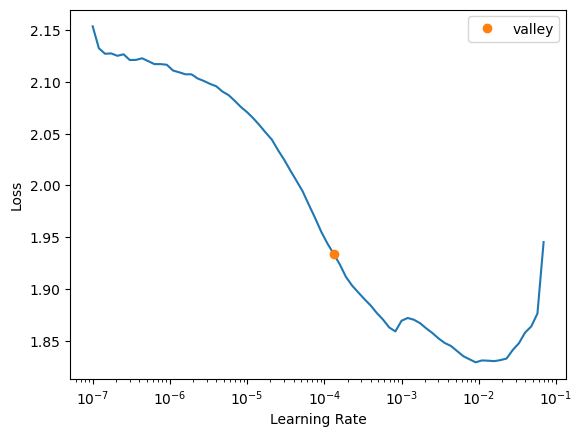

In [27]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy,
                   cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=20)],
                   wd=0.01).to_fp16()  # 添加权重衰减


model = ResNet(dls.c, [4,4,4,4])
learn = get_learner(model)

learn.lr_find()

In [28]:
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,accuracy,time
0,1.447856,1.455646,0.438953,01:02
1,1.226845,1.726743,0.427720,01:02
2,1.098932,1.542793,0.430260,01:02
3,1.021397,1.558497,0.456534,01:02
4,0.949754,1.055922,0.595819,01:02
5,0.909271,1.160903,0.570815,01:02
6,0.876193,1.233551,0.583024,01:02
7,0.835849,1.254291,0.575503,01:02
8,0.797111,2.754791,0.339910,01:02
9,0.772398,1.213297,0.559484,01:02


还不如昨天的结果呢...

In [29]:
# 保存
learn.export('RES_886990.pkl')

## 增加层数

SuggestedLRs(valley=0.00013182566908653826)

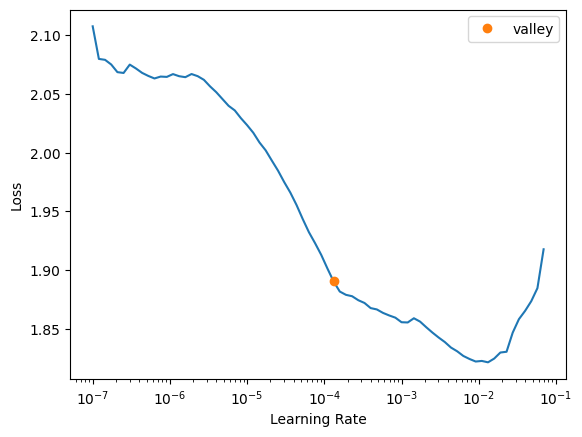

In [30]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy,
#                    cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=20)],
                   wd=0.05).to_fp16()  # 添加权重衰减


model = ResNet(dls.c, [5,5,5,5])
learn = get_learner(model)

learn.lr_find()

In [ ]:
learn.fit_one_cycle(55)

这里我没有跑完停了, 神经网络的茎有问题, 训练到后期指数爆炸, 加了批量归一化层

SuggestedLRs(valley=0.00015848931798245758)

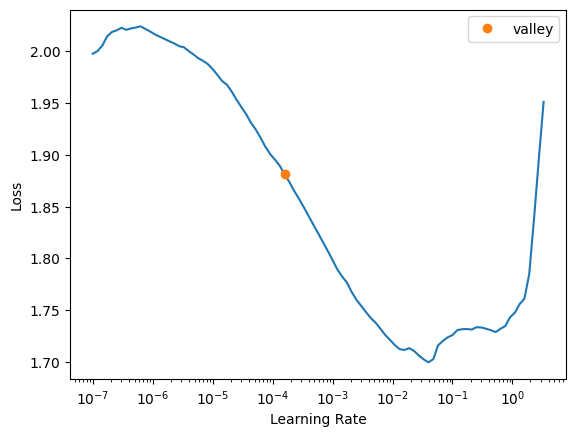

In [15]:
# def _resnet_stem(*sizes):
#     return [
#         nn.Conv1d(sizes[i], sizes[i+1], kernel_size=3, stride = 2 if i==0 else 1)
#             for i in range(len(sizes)-1)
#     ] + [nn.MaxPool1d(kernel_size=3, stride=2, padding=1)]
def _resnet_stem(*sizes):
    layers = []
    for i in range(len(sizes)-1):
        # 添加卷积层
        layers.append(nn.Conv1d(sizes[i], sizes[i+1], kernel_size=3, stride=2 if i==0 else 1, padding=1))
        # 添加批量归一化层
        layers.append(nn.BatchNorm1d(sizes[i+1]))
        # 添加激活层
        layers.append(nn.ReLU())
    # 添加最大池化层
    layers.append(nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
    return nn.Sequential(*layers)

def _conv_block(ni, nf, stride):
    return nn.Sequential(
        nn.Conv1d(ni, nf, kernel_size=3, stride=stride, padding=1),
        nn.BatchNorm1d(nf),
        nn.ReLU(),
        nn.Conv1d(nf, nf, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(nf)
    )


class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni, nf, stride)
        # 如果输入和输出通道数不同或应用了stride
        if ni != nf or stride != 1:
            self.idconv = nn.Sequential(
                nn.Conv1d(ni, nf, kernel_size=1, stride=stride),
                nn.BatchNorm1d(nf)
            )
        else:
            self.idconv = nn.Identity()

    def forward(self, x):
        identity = self.idconv(x)
        out = self.convs(x)
        return F.relu(out + identity)



class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
#         stem = _resnet_stem(1, 512, 256, 128, 64) # 我不希望一次增加太多参数, 原:1-->512
# #         stem = _resnet_stem(1, 32, 64, 64, 128, 256)
#         self.block_szs = [64, 64, 128, 256, 512, 512]
        stem = _resnet_stem(1, 32, 32, 64)
        self.block_szs = [64, 64, 128, 256, 512]
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool1d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], 128),
                         nn.BatchNorm1d(128),
                         nn.ReLU(),
                         nn.Linear(128, n_out))
    
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])

def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy,
                   cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=25)],
                   wd=0.05).to_fp16()  # 添加权重衰减

model = ResNet(dls.c, [3,3,3,3])
learn = get_learner(model)

learn.lr_find()

In [16]:
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,time
0,1.495297,1.393977,0.481832,00:36
1,1.250601,1.208119,0.548838,00:36
2,1.079690,1.130515,0.571303,00:36
3,0.952791,1.090275,0.588396,00:36
4,0.844522,1.172273,0.554601,00:36
5,0.770852,1.446467,0.536238,00:36
6,0.706294,1.171987,0.581168,00:36
7,0.679463,1.524165,0.516409,00:36
8,0.669396,1.312084,0.577652,00:36
9,0.664487,1.440992,0.537312,00:36


No improvement since epoch 24: early stopping


In [17]:
learn.export('RES_776910.pkl')

睡觉睡觉, 88应该是我的极限了

In [20]:
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,time
0,1.594470,1.510754,0.407013,01:16
1,1.340448,1.324440,0.492870,01:16
2,1.168295,1.186707,0.540047,01:16
3,1.066709,1.255746,0.525689,01:16
4,0.990726,1.089391,0.586931,01:16
5,0.937252,1.035896,0.608810,01:16
6,0.883590,1.096222,0.595233,01:16
7,0.847002,1.059281,0.591913,01:16
8,0.809299,1.129989,0.581852,01:16
9,0.780911,0.967395,0.641141,01:16


In [21]:
learn.export('RES_896171.pkl')

## 结果可视化分析

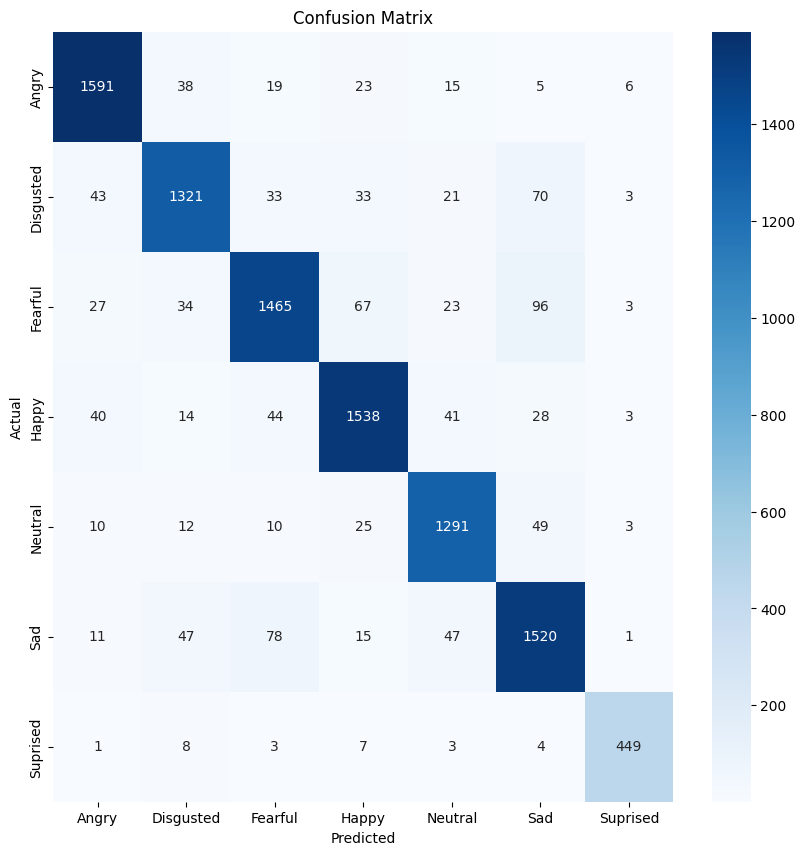

In [47]:
from fastai.interpret import Interpretation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

preds, targs = learn.get_preds()
interp = Interpretation.from_learner(learn)

# 混淆矩阵
y_true = targs.numpy()
y_pred = np.argmax(preds.numpy(), axis=1)
cm = confusion_matrix(y_true, y_pred)

# 可视化混淆矩阵
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_categories, yticklabels=label_categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [48]:
# 分类报告
print(classification_report(y_true, y_pred, target_names=label_categories))

              precision    recall  f1-score   support

       Angry       0.92      0.94      0.93      1697
   Disgusted       0.90      0.87      0.88      1524
     Fearful       0.89      0.85      0.87      1715
       Happy       0.90      0.90      0.90      1708
     Neutral       0.90      0.92      0.91      1400
         Sad       0.86      0.88      0.87      1719
    Suprised       0.96      0.95      0.95       475

    accuracy                           0.90     10238
   macro avg       0.90      0.90      0.90     10238
weighted avg       0.90      0.90      0.90     10238



# 结束

## CNN_LSTM
看到有个人用LSTM把正确率拉到了0.99(非同一数据集), 搭不出来...

In [1]:
import pandas as pd
# 加载保存的CSV文件
df_loaded_features = pd.read_csv('/kaggle/input/audio-emotions-features/audio_emotions_features.csv')

# 检查加载的数据
print(df_loaded_features.head())
print("Loaded Features Shape:", df_loaded_features.shape)

          0         1         2         3         4         5         6  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.251465  0.384277  0.503418  0.506836  0.512695  0.507324  0.507812   
2  0.053711  0.083008  0.109375  0.112305  0.149414  0.213379  0.206055   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.050781  0.082520  0.094727  0.090332  0.075195  0.093262  0.145508   

          7         8         9  ...       1905       1906       1907  \
0  0.000000  0.000000  0.000000  ...  10.159821 -13.579152 -14.357656   
1  0.503906  0.494629  0.491699  ...   6.583082  -8.579205 -15.144431   
2  0.205078  0.148926  0.063965  ...   4.956180   5.058086   4.853603   
3  0.002441  0.142578  0.264160  ...   0.245735 -10.770325   3.085566   
4  0.204590  0.250977  0.241211  ...   0.000000   0.000000   0.000000   

        1908       1909       1910       1911      1912       1913     label  
0  -6.026750  -7.200257 -10.158

In [2]:
df_loaded_features['label'] = df_loaded_features['label'].astype('category')

label_categories = df_loaded_features['label'].cat.categories
print(label_categories)

y = df_loaded_features['label'].cat.codes

Index(['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Suprised'], dtype='object')


In [3]:
y_cat = [label_categories[y[i]] for i in range(len(y))]
y_cat[-10:]

['Happy',
 'Happy',
 'Happy',
 'Happy',
 'Happy',
 'Happy',
 'Happy',
 'Happy',
 'Happy',
 'Happy']

In [4]:
import numpy as np
X = df_loaded_features.drop(columns=['label'])
y = df_loaded_features['label']

X = X.values.astype(np.float32)

X.shape

(51192, 1914)

In [13]:
X[0].shape

(1914,)

In [ ]:
from fastai.text.all import *

def get_x(r): return X[r]
def get_y(r): return y_cat[r]

# 定义DataBlock
dblock = DataBlock(blocks=(TransformBlock, CategoryBlock),
                   getters=[get_x, get_y],
                   splitter=RandomSplitter(valid_pct=0.2, seed=42))  # 20%的数据用作验证集

dls = dblock.dataloaders(np.arange(len(X)), bs=64)

In [23]:
x_train, y_train = dls.train.one_batch()
x_train.shape

torch.Size([64, 1914])

In [20]:
# 定义 LSTM 模型
model = nn.Sequential(
    nn.LSTM(1914, 256, batch_first=True),  # LSTM层
    nn.Dropout(0.2),  # Dropout 层
    nn.Linear(256, 128),  # 全连接层
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 7)  # 输出层
)

# class LSTMOutput(Module):
#     def forward(self, x):
#         return x[0][:, -1]

# # 将 LSTM 输出处理模块加入到 Sequential 模型中
# model = nn.Sequential(
#     model,
#     LSTMOutput(),
#     nn.Softmax(dim=1)
# )

In [31]:
from fastai.text.all import *  # 使用文本模块处理序列数据

dblock = DataBlock(blocks=(TransformBlock, CategoryBlock),
                   getters=[get_x, get_y],
                   splitter=RandomSplitter(valid_pct=0.2, seed=42))

dls = dblock.dataloaders(np.arange(len(X)), bs=512)

# 定义 LSTM 模型
class LSTMModel(Module):
    def __init__(self, n_out):
        self.lstm = nn.LSTM(1, 256, batch_first=True)  # 每个时间步长1个特征
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, n_out)

    def forward(self, x):
        x = x.unsqueeze(-1)  # 确保最后一个维度为1
        output, (hidden, _) = self.lstm(x)
        x = self.dropout1(hidden[-1])  # 只取最后一个 time step 的输出
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x

# 创建模型和 Learner
model = LSTMModel(dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

# 训练模型
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.945645,1.913702,0.162336,00:44
1,1.895326,1.861050,0.214300,00:44
2,1.886996,1.879375,0.192030,00:44
3,1.872748,1.857689,0.216253,00:44
4,1.845260,1.803344,0.238523,00:44
5,1.798495,1.757075,0.267923,00:44
6,1.767596,1.748707,0.276519,00:44
7,1.740213,1.727195,0.287849,00:44
8,1.724486,1.721097,0.289510,00:44
9,1.720191,1.719011,0.287947,00:44
